In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
from torch.autograd import Variable
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler() # define min max scaler

In [2]:
# read file
stock_path = "C:/Users/acer/Desktop/LAB/lab_2.csv"
stock_df = pd.read_csv(stock_path)
stock_df=stock_df.fillna(0)

In [3]:
train_set = stock_df[:2200]
test_set = stock_df[2200:]
print(train_set.shape)
print(test_set.shape)

(2200, 12)
(238, 12)


In [4]:
# every features in range(0 , 1)
train_set.describe()

,K value,D value,MACD,William,SMA,WMA,Momentum,RSI,A/D 0,CCI,Close r/f
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,0.478459,0.494744,0.515782,0.515950,0.425581,0.426475,0.464374,0.492458,0.445859,0.463808,1.000000
std,0.242761,0.231248,0.128572,0.292113,0.297391,0.296803,0.101128,0.251304,0.278231,0.159410,0.964113
min,0.004943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.272646,0.306148,0.453617,0.258398,0.180373,0.181665,0.419330,0.292431,0.208334,0.351748,0.000000
50%,0.469031,0.482729,0.512733,0.520003,0.364709,0.364416,0.461561,0.500000,0.415185,0.467025,1.000000
75%,0.691137,0.682273,0.585561,0.777773,0.712705,0.712135,0.514771,0.687486,0.687456,0.572115,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [5]:
# print the number of rise , flat , fall data
print("Train set Rise: %.4f"%(len(train_set[train_set["Close r/f"] == 2])*100 / len(train_set)))
print("Train set Flat: %.4f"%(len(train_set[train_set["Close r/f"] == 1])*100 / len(train_set)))
print("Train set Fall: %.4f"%(len(train_set[train_set["Close r/f"] == 0])*100 / len(train_set)))
print("Test set Rise: %.4f"%(len(test_set[test_set["Close r/f"] == 2])*100 / len(test_set)))
print("Test set Flat: %.4f"%(len(test_set[test_set["Close r/f"] == 1])*100 / len(test_set)))
print("Test set Fall: %.4f"%(len(test_set[test_set["Close r/f"] == 0])*100 / len(test_set)))


Train set Rise: 46.4545
Train set Flat: 7.0909
Train set Fall: 46.4545
Test set Rise: 49.5798
Test set Flat: 2.5210
Test set Fall: 47.8992


In [6]:
# declear training features data
features = []
for i in range(30,len(train_set)):
    x = train_set[i-30:i][["K value ","D value","William","MACD","SMA","WMA","Momentum","RSI","A/D 0","CCI"]].values
    features.append(x.tolist())
features = torch.FloatTensor(features)
features.size()

torch.Size([2170, 30, 10])

In [7]:
# declear trainging labels data
labels = []
for i in range(31,len(train_set)+1):
    x = train_set[i-1:i]["Close r/f"]
    labels.append(x.tolist())
labels = torch.LongTensor(labels).view(-1)
labels.size()

torch.Size([2170])

In [8]:
#hy parameter
torch.manual_seed(1)
EPOCH = 10
BATCH_SIZE = 64
TIME_STEP = 30
INPUT_SIZE = 10
LR = 0.001

In [9]:

#Mini-Batch

torch_dataset = Data.TensorDataset(features,labels)
train_loader = Data.DataLoader(
    dataset = torch_dataset,
    batch_size = BATCH_SIZE,
    num_workers = 2,
    shuffle=True,
)

In [10]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
             torch.nn.Linear(TIME_STEP * INPUT_SIZE, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 12), 
            torch.nn.ReLU(True), 
            torch.nn.Linear(12, 3))
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 64),
            torch.nn.ReLU(True), 
            torch.nn.Linear(64, TIME_STEP * INPUT_SIZE), 
            torch.nn.Tanh())

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return encoder,decoder

In [11]:
model = autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=12, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=300, bias=True)
    (5): Tanh()
  )
)


In [12]:
# define optimizer and loss function 
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=0.0005)
# adject learning rate . when loss don't fall , lr = lr * factor  , min lr = 0.0001
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.9,min_lr=0.0001)
# crossentroy loss 
loss_func = torch.nn.MSELoss()

In [13]:

#delcear testing features and labels

test_features = []
for i in range(30,len(test_set)):
    x = test_set[i-30:i][["K value ","D value","William","MACD","SMA","WMA","Momentum","RSI","A/D 0","CCI"]].values
    test_features.append(x.tolist())
test_features = torch.FloatTensor(test_features)
test_labels = []
for i in range(31,len(test_set)+1):
    x = test_set[i-1:i]["Close r/f"]
    test_labels.append(x.tolist())
test_labels = torch.FloatTensor(test_labels).view(-1)

In [14]:
'''
Training 
'''
LOSS = []
TEST_LOSS = []
for epoch in range(EPOCH):
    loss_total = 0
    for step,(inputs,targets) in enumerate(train_loader):
        inputs = inputs.view(-1,TIME_STEP * INPUT_SIZE)
        #reshape the features to (batch,time_step*input_size)
        inputs_n = inputs.view(-1,TIME_STEP * INPUT_SIZE)
       
    
        inputs_n =  inputs_n + torch.randn(TIME_STEP * INPUT_SIZE)
        # Clip the images to be between 0 and 1
        inputs_n = np.clip( inputs_n, 0., 1.)

        
        # start trainnig 
        _,output = model(inputs_n)
        # calculate loss  (cross entroy)
        loss = loss_func(output,inputs)
        # clear the gradients of all optimized variables(from last training)
        optimizer.zero_grad()
        
        # back propagation
        loss.backward()
        optimizer.step()
        # sum of loss
        loss_total = loss_total + loss
        
        # print training info every 10 steps
        if((step+1) %10 == 0):
            # average of loss in 10 steps
            avg = loss_total / 10
            LOSS.append(avg.tolist())
            
            # test data
            test_features = torch.Tensor(test_features).view(-1,30*10)
            _,out = model(test_features)
            
            test_loss = loss_func(out,test_features)
            TEST_LOSS.append(test_loss.tolist())
            # print the epoch , steps , average loss , accuracy 
            print("Epoch: %4d|steps: %4d|Train Avg Loss: %.4f |Test Loss: %4f"
                  %(epoch+1,step+1,avg,test_loss))
            
            # inital variable
            loss_total = 0
    # updata learning rate
    #scheduler.step(loss)
        


Epoch:    1|steps:   10|Train Avg Loss: 0.2610 |Test Loss: 0.207577
Epoch:    1|steps:   20|Train Avg Loss: 0.2040 |Test Loss: 0.151431
Epoch:    1|steps:   30|Train Avg Loss: 0.1419 |Test Loss: 0.084279
Epoch:    2|steps:   10|Train Avg Loss: 0.0726 |Test Loss: 0.049082
Epoch:    2|steps:   20|Train Avg Loss: 0.0614 |Test Loss: 0.042721
Epoch:    2|steps:   30|Train Avg Loss: 0.0571 |Test Loss: 0.041195
Epoch:    3|steps:   10|Train Avg Loss: 0.0551 |Test Loss: 0.041090
Epoch:    3|steps:   20|Train Avg Loss: 0.0571 |Test Loss: 0.040880
Epoch:    3|steps:   30|Train Avg Loss: 0.0557 |Test Loss: 0.040825
Epoch:    4|steps:   10|Train Avg Loss: 0.0551 |Test Loss: 0.040797
Epoch:    4|steps:   20|Train Avg Loss: 0.0565 |Test Loss: 0.040781
Epoch:    4|steps:   30|Train Avg Loss: 0.0544 |Test Loss: 0.040727
Epoch:    5|steps:   10|Train Avg Loss: 0.0549 |Test Loss: 0.040693
Epoch:    5|steps:   20|Train Avg Loss: 0.0547 |Test Loss: 0.040699
Epoch:    5|steps:   30|Train Avg Loss: 0.0547 |

In [15]:
import matplotlib.pyplot as plt

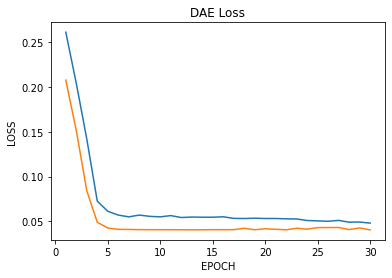

In [16]:
x = np.linspace(1,30,30)
y = np.array(LOSS)
plt.plot(x,y)
y = np.array(TEST_LOSS)
plt.plot(x,y)
plt.title("DAE Loss")
plt.xlabel("EPOCH")
plt.ylabel("LOSS")
plt.show()

In [17]:
features = features.view(-1,TIME_STEP*INPUT_SIZE)
en_features,de_features = model(features)


In [18]:
print(inputs)

tensor([[0.2764, 0.2203, 0.5556,  ..., 0.2500, 0.5000, 0.5966],
        [0.1141, 0.1559, 0.8290,  ..., 0.5439, 0.2084, 0.4440],
        [0.1465, 0.2494, 0.9643,  ..., 0.9412, 0.1429, 0.1975],
        ...,
        [0.8497, 0.8721, 0.0769,  ..., 0.4444, 0.8571, 0.5215],
        [0.6793, 0.6162, 0.3548,  ..., 0.7308, 0.1429, 0.2995],
        [0.2268, 0.3103, 0.7000,  ..., 0.7083, 0.2813, 0.4525]])


In [19]:
print(inputs_n)

tensor([[1.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.4928],
        [1.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.3402],
        [1.0000, 0.0000, 1.0000,  ..., 0.3196, 0.0000, 0.0937],
        ...,
        [1.0000, 0.5529, 0.6971,  ..., 0.0000, 0.0000, 0.4178],
        [1.0000, 0.2970, 0.9750,  ..., 0.1092, 0.0000, 0.1957],
        [1.0000, 0.0000, 1.0000,  ..., 0.0868, 0.0000, 0.3487]])


In [20]:
print(output)

tensor([[0.4764, 0.5008, 0.5407,  ..., 0.5106, 0.4221, 0.4603],
        [0.4181, 0.4387, 0.4974,  ..., 0.4499, 0.4027, 0.4212],
        [0.4135, 0.4338, 0.4941,  ..., 0.4452, 0.4012, 0.4182],
        ...,
        [0.4857, 0.5106, 0.5475,  ..., 0.5201, 0.4253, 0.4666],
        [0.4796, 0.5042, 0.5434,  ..., 0.5141, 0.4234, 0.4626],
        [0.4890, 0.5141, 0.5498,  ..., 0.5233, 0.4263, 0.4688]],
       grad_fn=<TanhBackward>)


In [21]:
de_features.size()

torch.Size([2170, 300])